In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra; using Distributions
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`


      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
  [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


# Ejercicio examen (versión estocástica)

Consideremos un modelo de ciclo real clásico, pero incorporando una restricción de no-negatividad sobre la inversión.


Función de producción Cobb-Douglas sin trabajo: $f(K,Z)=ZK^\alpha$.

Denotando a $Y$ como la producción tenemos $Y_t=f(K_{t-1},Z_t)$.

Conocemos las condiciones iniciales $K_{-1}$ y $Z_0$

$Z_t$ es un proceso de markov de memoria 1 con dominio en $\{Z_a \, Z_b \, Z_c\}$
Con matriz de transición:
$ \Pi = \begin{pmatrix}
p_{aa} & p_{ab} & p_{ac}\\
p_{ba} & p_{bb} & p_{bc}\\
p_{ca} & p_{cb} & p_{cc}
\end{pmatrix}$



Las preferencias están dadas por una función de Bernoulli (o utilidad instantánea) CRRA con parámetro $\gamma$:

Si $\gamma \neq 1$ entonces $u(c)=\frac{c^{1-\gamma}-1}{1-\gamma}$ 

Si $\gamma = 1$ entonces $u(c)=ln(c)$ 

La utilidad esperada intertemporal está dada por

$U_0(\{C_t(Z_t)\}_{t=0}^\infty) = \mathbb{E} \big\{ \sum_{t=0}^\infty \beta^{t} u(C_t(Z_t)) \,|\,Z_0\, \big\} $

$C_t(Z_t)\geq0$



El capital se deprecia a una tasa $\delta$ de forma que:

$K_t=K_{t-1}(1-\delta)+I_t(Z_t)$ (para todo $t$ para todo $Z_t$)

Donde $K_t>0$

**A difernecia de lo habitual impondremos:** $I_t(Z_t)\geq0$



Nos limitaremos al problema del planner, que podemos definirlo como:

$$
V(K_{-1},Z_0) = \max_{\{C_t(Z_t)\}_{t=0}^\infty,\{I_t(Z_t)\}_{t=0}^\infty} \mathbb{E} \big\{ \sum_{t=0}^\infty \beta^{t} u(C_t(Z_t)) \,|\,Z_0\, \big\}
$$

sujeto a:
$$
Z_tK_{t-1}^\alpha \geq I_t(Z_t)+C_t(Z_t)\\
K_t=K_{t-1}(1-\delta)+I_t(Z_t)\\
K_t\geq0\;I_t(Z_t)\geq0\;C_t(Z_t)\geq0\\
U_0(\{C_t(Z_t)\}_{t=0}^\infty)<\infty
$$

### Consignas

1. Escriba la ecuación de Bellman que caracteriza este problema. Muestre que la $V$ es única y continua.

2. Defina un equilibrio recursivo para este modelo

Para la siguiente calibración del modelo:

- $\gamma=1$
- $\beta = 0.9$
- $\delta = 0.01$
- $\alpha = 0.5$
- $Z=(0.75\; 1\; 1.25)$
- $ \Pi = \begin{pmatrix}
0.61 & 0.34 & 0.05\\
0.24 & 0.52 & 0.24\\
0.05 & 0.34 & 0.61
\end{pmatrix}$


Utilizando VFI se pide:

3. Compute la evolución temporal del consumo si $K_0=2$. Comparelo con la trayectoria del consumo para un modelo sin la restricción de no-negatividad sobre al inversión. 

4. Compute la evolución temporal del consumo si $K_0=21$. Comparelo con la trayectoria del consumo para un modelo sin la restricción de no-negatividad sobre al inversión.


# Resolución punto 4

In [98]:
γ = 1.0
α = 0.5 
𝛿 = 0.01
function u(c)
    if c>0
        γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA
    else
        0
    end
end

Z=[0.75 1.0 1.25]
Π=[0.61 0.34 0.05; 0.24 0.52 0.24; 0.05 0.34 0.61]
Z_grid = 1:3
f(k,z)=Z[z]*k^α+(1-𝛿)*k # Cobb-Douglas with depretiation

@show K_0 = 21.0 # initial condition
β = 0.9

V_0(k,z) = u(f(k,z)-k)/(1-β)

Zmax=maximum(Z)
Zmin=minimum(Z)
# Kmax = (Zmax/𝛿)^(1/(1-α)) # Demasiado grande
@show Kss_max = ((β*Zmax*α)/(1-β*(1-𝛿)))^(1/(1-α))
@show Kss_min = ((β*Zmin*α)/(1-β*(1-𝛿)))^(1/(1-α))

n=500 # grid points

K_grid = range(1e-10 , max(K_0,Kss_max*1.25), length=n)

V_0_mat=[V_0(k,z) for k in K_grid, z in Z_grid];

K_grid

K_0 = 21.0 = 21.0
Kss_max = ((β * Zmax * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 26.63128103694976
Kss_min = ((β * Zmin * α) / (1 - β * (1 - 𝛿))) ^ (1 / (1 - α)) = 9.587261173301915


1.0e-10:0.06671162584386212:33.2891012961872

In [99]:
# PARA ENTENDER COMO FUNCIONA LA COTA INFERIOR FUNCION MAXIMIZE (no hace nada "útil" esta celda)
V_lin(z) = LinearInterpolation(K_grid, V_0_mat[:,z], extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function
V_new=zeros(length(K_grid),length(Z_grid)); g_new=zeros(length(K_grid),length(Z_grid)); K_min=K_grid[1]

objectives = (K -> u.((f(k,2)-K)) + β * Π[2,:]' * [V_lin(z)(K) for z in Z_grid]   for k in K_grid)

results_a = maximize.(objectives, K_grid.*(1-𝛿),f.(K_grid,2)) 
aa =  Optim.maximizer.(results_a)-K_grid.*(1-𝛿)
@show minimum(aa)

results_b = maximize.(objectives, K_min,f.(K_grid,2)) 
bb =  Optim.maximizer.(results_b) - K_grid.*(1-𝛿)
@show minimum(bb)

;

minimum(aa) = 3.5139780307543474e-16
minimum(bb) = -1.646118247316867


In [100]:
function T(V, K_grid, Z_grid)
    V_lin(z) = LinearInterpolation(K_grid, V[:,z], extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function
    V_new=zeros(length(K_grid),length(Z_grid)); g_new=zeros(length(K_grid),length(Z_grid));
    for z in Z_grid
        objectives = (K -> u.((f(k,z)-K)) + β * Π[z,:]' * [V_lin(z)(K) for z in Z_grid]   for k in K_grid)
        results = maximize.(objectives, K_grid.*(1-𝛿),f.(K_grid,z)) 
        V_new[:,z] = Optim.maximum.(results)
        g_new[:,z] = Optim.maximizer.(results)
    end
    return [V_new, g_new]
end

T (generic function with 1 method)

In [101]:
function T_sin_restriccion(V, K_grid, Z_grid)
    V_lin(z) = LinearInterpolation(K_grid, V[:,z], extrapolation_bc = Line()) # linear interpolation of the vectorized (or not) function
    V_new=zeros(length(K_grid),length(Z_grid)); g_new=zeros(length(K_grid),length(Z_grid)); K_min=K_grid[1]
    for z in Z_grid
        objectives = (K -> u.((f(k,z)-K)) + β * Π[z,:]' * [V_lin(z)(K) for z in Z_grid]   for k in K_grid)
        results = maximize.(objectives, K_min,f.(K_grid,z)) 
        V_new[:,z] = Optim.maximum.(results)
        g_new[:,z] = Optim.maximizer.(results)
    end
    return [V_new, g_new]
end

T_sin_restriccion (generic function with 1 method)

Antes era 
``` results = maximize.(objectives, K_min,f.(K_grid,z)) ```

Ahora es 
``` results = maximize.(objectives, K_grid.*(1-𝛿),f.(K_grid,z)) ```

El mínimo valor para K' no es constante, sino que varía según K

Number of iterations: 80
Distance between last two value functions: 9.397071411174581e-5


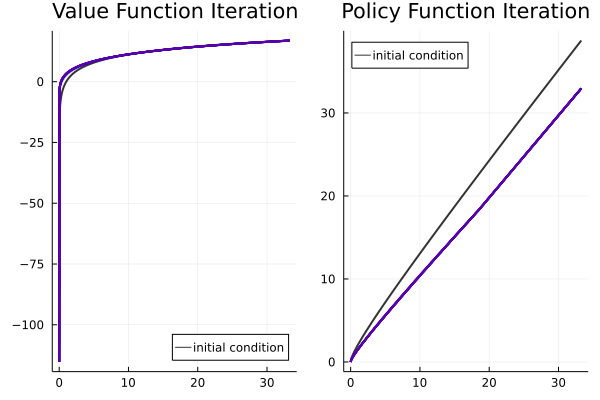

In [102]:
V_mat = V_0_mat
g_mat = [f(x,s) for x in K_grid, s in Z_grid]; # matrix

pltV=plot(K_grid, V_mat[:,2], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g_mat[:,2], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 200   
tol = 0.0001 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance

i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V_mat, K_grid, Z_grid)
    if mod(i,5)==0
        plot!(pltV,K_grid, V_new[:,2], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
        plot!(pltg,K_grid, g_new[:,2], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    end
    distance = norm(V_new - V_mat)
    i += 1
    V_mat = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g_fun(z)=LinearInterpolation(K_grid, g_new[:,z], extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

In [103]:
@show minimum(g_new[:,1]-K_grid.*(1-𝛿))
@show minimum(g_new[:,2]-K_grid.*(1-𝛿))
@show minimum(g_new[:,3]-K_grid.*(1-𝛿))
;

minimum(g_new[:, 1] - K_grid .* (1 - 𝛿)) = 4.3118822363976175e-16
minimum(g_new[:, 2] - K_grid .* (1 - 𝛿)) = 3.5139780307543474e-16
minimum(g_new[:, 3] - K_grid .* (1 - 𝛿)) = 4.441482962530214e-16


In [104]:
V_mat_s = V_0_mat
g_mat_s = [f(x,s) for x in K_grid, s in Z_grid]; # matrix

max_iter = 50   
tol = 0.0001 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance

i=1
while i < max_iter && distance > tol
    global V_new_s, g_new_s = T_sin_restriccion(V_mat_s, K_grid, Z_grid)
    distance = norm(V_new_s - V_mat_s)
    i += 1
    V_mat_s = V_new_s # copy contents into v.  Also could have used v[:] = v_next
end
g_fun_sin_restriccion(z)=LinearInterpolation(K_grid, g_new_s[:,z], extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

Number of iterations: 50
Distance between last two value functions: 0.004025449007829672


In [105]:
@show minimum(g_new_s[:,1]-K_grid.*(1-𝛿))
@show minimum(g_new_s[:,2]-K_grid.*(1-𝛿))
@show minimum(g_new_s[:,3]-K_grid.*(1-𝛿))
;

minimum(g_new_s[:, 1] - K_grid .* (1 - 𝛿)) = -2.0417599014453813
minimum(g_new_s[:, 2] - K_grid .* (1 - 𝛿)) = -0.8806627406338308
minimum(g_new_s[:, 3] - K_grid .* (1 - 𝛿)) = 1.0004441482607196e-12


In [106]:
function cadena_simu(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # es una matriz cuadrada?
    N = size(P)[1]

    dists = [Categorical(P[i, :]) for i in 1:N]  # crea N distribuciones

    X = fill(0, sample_size) # crea un vector
    X[1] = init # primer estado

    for t in 2:sample_size
        dist = dists[X[t-1]] # selecciona la distribucion correspondiente
        X[t] = rand(dist) # saca un valor aleatorio segun la distribución
    end
    return X
end

cadena_simu (generic function with 1 method)

In [114]:
Time=500
Z_1 = cadena_simu(Π, init = 2, sample_size = Time)
Z_2 = cadena_simu(Π, init = 2, sample_size = Time)
Z_3 = cadena_simu(Π, init = 2, sample_size = Time);



In [115]:
y_path = fill(0.0, Time)
c_path = fill(0.0, Time)
i_path = fill(0.0, Time)
K_path = fill(0.0, Time)
y_path[1] = f(K_0,2)
K_path[1] = g_fun(Z_1[1])(K_0)
c_path[1] = y_path[1] - K_path[1]
i_path[1] = K_path[1] - K_0*(1-𝛿)

for t in 2:(Time)  
    K_path[t] = g_fun(Z_1[t])(K_path[t-1])
    y_path[t] = f(K_path[t-1],Z_1[t])
    c_path[t] = y_path[t] - K_path[t]
    i_path[t] = K_path[t] - K_path[t-1]*(1-𝛿)
end

In [116]:
y_path_s = fill(0.0, Time)
c_path_s = fill(0.0, Time)
i_path_s = fill(0.0, Time)
K_path_s = fill(0.0, Time)
y_path_s[1] = f(K_0,2)
K_path_s[1] = g_fun_sin_restriccion(Z_1[1])(K_0)
c_path_s[1] = y_path_s[1] - K_path_s[1]
i_path_s[1] = K_path_s[1] - K_0*(1-𝛿)

for t in 2:(Time)  
    K_path_s[t] = g_fun_sin_restriccion(Z_1[t])(K_path_s[t-1])
    y_path_s[t] = f(K_path_s[t-1],Z_1[t])
    c_path_s[t] = y_path_s[t] - K_path_s[t] 
    i_path_s[t] = K_path_s[t] - K_path_s[t-1]*(1-𝛿)

end

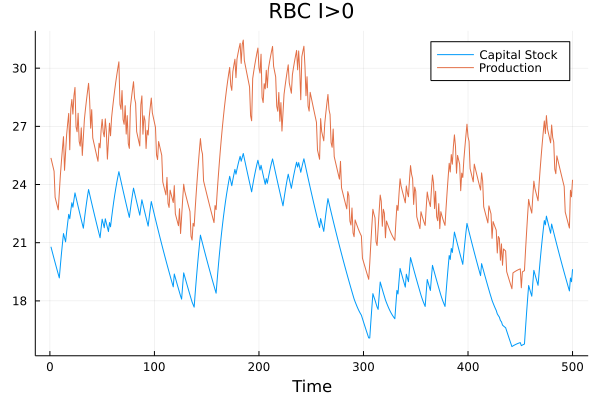

In [117]:
plot(1:Time,K_path,label="Capital Stock",title="RBC I>0",xlabel="Time")
#plot!(1:Time,c_path,label="Consumption")
plot!(1:Time,y_path,label="Production")

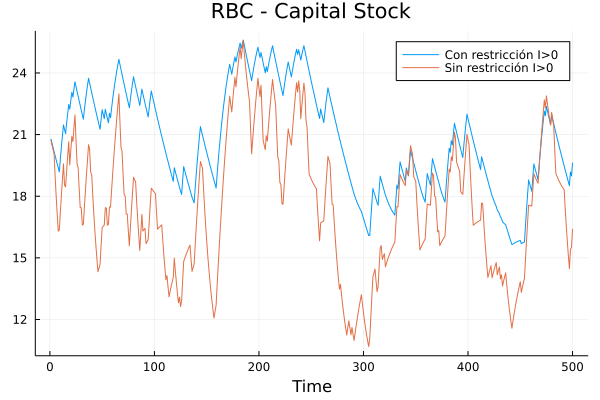

In [118]:
plot(1:Time,K_path,label="Con restricción I>0",title="RBC - Capital Stock",xlabel="Time")
plot!(1:Time,K_path_s,label="Sin restricción sobre I")

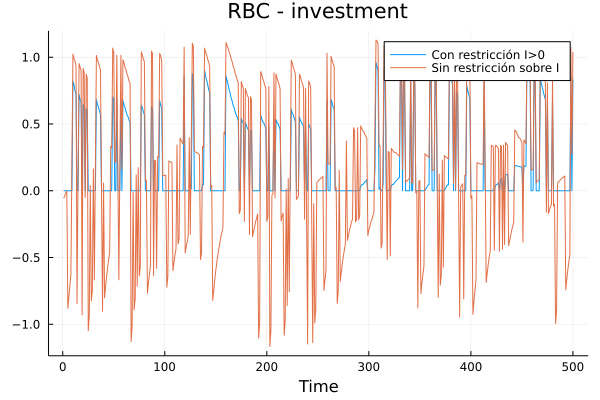

In [119]:
plot(1:Time,i_path,label="Con restricción I>0",title="RBC - investment",xlabel="Time")
plot!(i_path_s,label="Sin restricción sobre I")


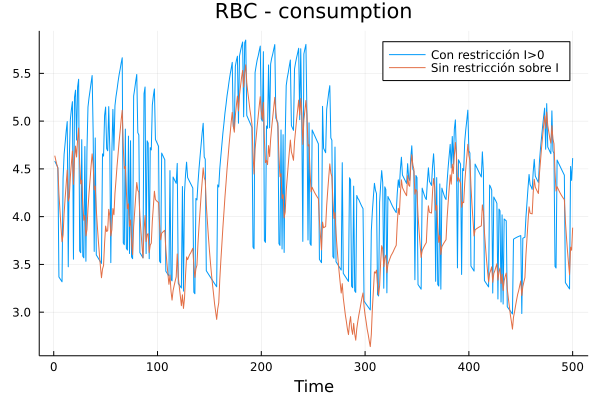

In [120]:
plot(1:Time,c_path,label="Con restricción I>0",title="RBC - consumption",xlabel="Time")
plot!(c_path_s,label="Sin restricción sobre I")